In [58]:
# SKIP HERE WHEN WORKING LOCALLY
 #Starter code
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset
event_data = "s3://udacitysparkify/final_df_processed.json"
df = spark.read.json(event_data)


In [1]:
# Installing the Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, when
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import datediff
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import IntegerType, FloatType, StringType, StructField, StructType



# Installing Spark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#pyspark label encoder


# Installing python data science libraries
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


%matplotlib inline

In [2]:
# how to see full columns in pandas
pd.set_option('display.max_columns', None)

In [3]:
# set color palette for all plots
sns.set_palette("Set2")
# set style for all plots
sns.set_style("whitegrid")

In [4]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()
# read the data from the json file
df_user = spark.read.json('data/final_df_processed.json')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/03 12:11:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# make user table
df_user.createOrReplaceTempView('user_table')

23/01/03 12:11:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
churn_df = spark.sql('''
                    SELECT userId, churn
                    FROM user_table
                    ''').toPandas()

churn_df = pd.get_dummies(churn_df, columns=['churn']).\
drop('churn_0', axis=1).\
    rename(columns={'churn_1': 'churned'})

churn_df.drop_duplicates(subset = "userId", keep='last', inplace=True)

churn_df.churned.value_counts()


0    220
1      5
Name: churned, dtype: int64

In [7]:
# make spark dataframe from pandas dataframe
churn_df = spark.createDataFrame(churn_df)

# join the user table with the churn table
df_user = df_user.join(churn_df, on='userId', how='left')

/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [9]:
# check if the join was successful
df_user.toPandas().head()

,userId,artist,auth,browser,churn,cluster,day,device,ds_reg,ds_reg_at_event,firstName,fulldate,gender,hour,itemInSession,lastName,length,level,location,method,month,page,registration,registration_dt,sessionId,song,status,ts,userAgent,week,weekday,weekday_hrf,year,churned
0,100010,brutha,Logged In,Safari,0,0,8.0,iPhone,43,11,Darianna,2018-10-08 15:05:32,F,15.0,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0
1,100010,angels and airwaves,Logged In,Safari,0,0,8.0,iPhone,43,11,Darianna,2018-10-08 15:47:38,F,15.0,20,Carpenter,302.05342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,The Gift,200,1539006458000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0
2,100010,dr. dre / eminem / alvin joiner,Logged In,Safari,0,0,8.0,iPhone,43,11,Darianna,2018-10-08 15:59:00,F,15.0,24,Carpenter,244.21832,free,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,What's The Difference,200,1539007140000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0
3,100010,marumari,Logged In,Safari,0,0,8.0,iPhone,43,11,Darianna,2018-10-08 16:49:37,F,16.0,38,Carpenter,253.59628,free,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,Baby M,200,1539010177000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0
4,100010,None,Logged In,Safari,0,0,15.0,iPhone,43,18,Darianna,2018-10-15 13:48:09,F,13.0,4,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,10.0,Home,1.538016e+12,2018-09-27 04:45:40,78,None,200,1539604089000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",42.0,0.0,Monday,2018.0,0


In [10]:
# make table
df_user.createOrReplaceTempView('user_table')

In [11]:
# show unique users who churned
spark.sql('''
            SELECT DISTINCT userId
            FROM user_table
            WHERE churned = 1
            ''').show()

+------+
|userId|
+------+
|   125|
|100015|
|100024|
|100011|
|    51|
+------+



In [12]:
# a label encoder function for working with spark dataframes
def label_encoder(df, col):
    '''
    Encodes a categorical column in a spark dataframe.
    
    Parameters:
    df (spark dataframe): the dataframe containing the categorical column
    col (str): the name of the categorical column
    
    Returns:
    spark dataframe: the dataframe containing the encoded categorical column
    '''
    # get the distinct values in the column
    distinct_values = df.select(col).distinct().toPandas()[col].values
    # create a dictionary to map the distinct values to integers
    mapping_dict = {val: i for i, val in enumerate(distinct_values)}
    # create a udf to encode the categorical column
    encoder = udf(lambda x: mapping_dict[x])
    # encode the categorical column
    df = df.withColumn(col, encoder(col))
    
    return df

In [13]:
# create list of categorical variables
cat_vars = ['gender', 'level', 'browser', 'device']

# label encode the categorical variables
for col in cat_vars:
    df_user = label_encoder(df_user, col)


In [14]:
# check if the label encoding worked
df_user.toPandas().head(2)

,userId,artist,auth,browser,churn,cluster,day,device,ds_reg,ds_reg_at_event,firstName,fulldate,gender,hour,itemInSession,lastName,length,level,location,method,month,page,registration,registration_dt,sessionId,song,status,ts,userAgent,week,weekday,weekday_hrf,year,churned
0,100010,brutha,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:05:32,0,15.0,2,Carpenter,263.13098,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0
1,100010,angels and airwaves,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:47:38,0,15.0,20,Carpenter,302.05342,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,The Gift,200,1539006458000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0


In [15]:
# function to get aggregate statistics for a column per userID, using PySpark API
# fix str object not callable error
def get_agg_stats(df, col, agg_func):
    '''
    Gets aggregate statistics for a column per userID, using PySpark API.
    
    Parameters:
    df (spark dataframe): the dataframe containing the column
    col (str): the name of the column
    agg_func (str): the name of the aggregate function
    
    Returns:
    spark dataframe: the dataframe containing the aggregate statistics
    '''
    # get the aggregate statistics
    temp = df.groupBy('userId').agg({col: agg_func}).toPandas()
    # rename the column
    temp = temp.rename(columns={col: col + '_' + agg_func})
    # create a spark dataframe
    temp = spark.createDataFrame(temp)
    # join the aggregate statistics to the user table
    df = df.join(temp, on='userId', how='left')
    # user table
    df.createOrReplaceTempView('user_table')
     
    return df

In [16]:
# calculate the aggregate statistics for the hour variable
for agg_func in ['min', 'max', 'stddev']:
    for col in ['hour','itemInSession']:
        df_user = get_agg_stats(df_user, col, agg_func)

/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .

In [17]:
# user table
df_user.createOrReplaceTempView('user_table')

In [18]:
# check if the aggregate statistics were calculated correctly
df_user.toPandas().head(2)

,userId,artist,auth,browser,churn,cluster,day,device,ds_reg,ds_reg_at_event,firstName,fulldate,gender,hour,itemInSession,lastName,length,level,location,method,month,page,registration,registration_dt,sessionId,song,status,ts,userAgent,week,weekday,weekday_hrf,year,churned,min(hour),min(itemInSession),max(hour),max(itemInSession),stddev(hour),stddev(itemInSession)
0,100010,brutha,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:05:32,0,15.0,2,Carpenter,263.13098,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366
1,100010,angels and airwaves,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:47:38,0,15.0,20,Carpenter,302.05342,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,The Gift,200,1539006458000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366


## Get Aggregate Page Views

In [19]:
# how many times pages were visited per user
pages_df = spark.sql('''
                            SELECT userId, page, count(*) as page_visits
                            FROM user_table
                            GROUP BY userId, page
                            ''').toPandas()

In [20]:
pages_df.head(2)

,userId,page,page_visits
0,100010,NextSong,285
1,100010,Home,12


In [21]:
pages_df.pivot(index='userId', columns='page', values='page_visits').fillna(0).reset_index()
# rename the columns

page,userId,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,10,2.0,12.0,9.0,0.0,0.0,7.0,0.0,1.0,31.0,11.0,741.0,1.0,1.0,8.0,0.0,0.0,4.0,37.0,0.0
1,100,13.0,50.0,64.0,0.0,0.0,32.0,4.0,19.0,108.0,35.0,2768.0,26.0,5.0,11.0,1.0,2.0,27.0,148.0,1.0
2,100001,0.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,11.0,7.0,141.0,14.0,0.0,1.0,0.0,0.0,2.0,8.0,2.0
3,100002,0.0,1.0,5.0,0.0,0.0,4.0,0.0,0.0,7.0,1.0,202.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,100003,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,7.0,3.0,52.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,95,6.0,33.0,48.0,0.0,0.0,15.0,5.0,21.0,68.0,28.0,1743.0,51.0,0.0,14.0,1.0,0.0,25.0,91.0,5.0
221,96,4.0,40.0,54.0,0.0,0.0,20.0,2.0,9.0,75.0,24.0,1859.0,17.0,1.0,13.0,1.0,1.0,24.0,93.0,4.0
222,97,7.0,32.0,70.0,0.0,0.0,19.0,1.0,18.0,108.0,34.0,2052.0,26.0,2.0,12.0,0.0,1.0,12.0,109.0,3.0
223,98,4.0,45.0,58.0,0.0,0.0,25.0,4.0,16.0,119.0,39.0,2476.0,30.0,4.0,13.0,0.0,1.0,22.0,115.0,2.0


In [22]:
# pivot the pages_df dataframe
pages_df = pages_df.pivot(index='userId', columns='page', values='page_visits').fillna(0).reset_index()
# rename the columns
pages_df = pages_df.rename(columns={'About': 'about', 
'Add Friend': 'add_friend', 
'Add to Playlist': 'add_playlist',
'Downgrade': 'downgrade', 'Error': 'error',
'Help': 'help', 'Home': 'home',
'Logout': 'logout', 'NextSong': 'next_song', 
'Roll Advert': 'roll_advert', 'Save Settings': 'save_settings',
'Settings': 'settings', 
'Submit Downgrade': 'submit_downgrade',
'Submit Upgrade': 'submit_upgrade', 'Thumbs Down': 'thumbs_down', 
'Thumbs Up': 'thumbs_up', 'Upgrade': 'upgrade',
'Cancellation Confirmation': 'cancel_confirmation'})

# head
pages_df.head()

page,userId,about,add_friend,add_playlist,Cancel,cancel_confirmation,downgrade,error,help,home,logout,next_song,roll_advert,save_settings,settings,submit_downgrade,submit_upgrade,thumbs_down,thumbs_up,upgrade
0,10,2.0,12.0,9.0,0.0,0.0,7.0,0.0,1.0,31.0,11.0,741.0,1.0,1.0,8.0,0.0,0.0,4.0,37.0,0.0
1,100,13.0,50.0,64.0,0.0,0.0,32.0,4.0,19.0,108.0,35.0,2768.0,26.0,5.0,11.0,1.0,2.0,27.0,148.0,1.0
2,100001,0.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,11.0,7.0,141.0,14.0,0.0,1.0,0.0,0.0,2.0,8.0,2.0
3,100002,0.0,1.0,5.0,0.0,0.0,4.0,0.0,0.0,7.0,1.0,202.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,100003,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,7.0,3.0,52.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [23]:
# join the pages_df dataframe to the user table without producing null values
temp = df_user.join(spark.createDataFrame(pages_df), on='userId', how='left')

/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [24]:
temp.createOrReplaceTempView('all_data')

In [25]:
temp.toPandas().head(5)

,userId,artist,auth,browser,churn,cluster,day,device,ds_reg,ds_reg_at_event,firstName,fulldate,gender,hour,itemInSession,lastName,length,level,location,method,month,page,registration,registration_dt,sessionId,song,status,ts,userAgent,week,weekday,weekday_hrf,year,churned,min(hour),min(itemInSession),max(hour),max(itemInSession),stddev(hour),stddev(itemInSession),about,add_friend,add_playlist,Cancel,cancel_confirmation,downgrade,error,help,home,logout,next_song,roll_advert,save_settings,settings,submit_downgrade,submit_upgrade,thumbs_down,thumbs_up,upgrade
0,100010,brutha,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:05:32,0,15.0,2,Carpenter,263.13098,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,1.0,4.0,8.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,285.0,54.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
1,100010,angels and airwaves,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:47:38,0,15.0,20,Carpenter,302.05342,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,The Gift,200,1539006458000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,1.0,4.0,8.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,285.0,54.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
2,100010,dr. dre / eminem / alvin joiner,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:59:00,0,15.0,24,Carpenter,244.21832,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,What's The Difference,200,1539007140000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,1.0,4.0,8.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,285.0,54.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
3,100010,marumari,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 16:49:37,0,16.0,38,Carpenter,253.59628,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,Baby M,200,1539010177000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,1.0,4.0,8.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,285.0,54.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
4,100010,None,Logged In,1,0,0,15.0,1,43,18,Darianna,2018-10-15 13:48:09,0,13.0,4,Carpenter,NaN,0,"Bridgeport-Stamford-Norwalk, CT",GET,10.0,Home,1.538016e+12,2018-09-27 04:45:40,78,None,200,1539604089000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",42.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,1.0,4.0,8.0,0.0,0.0,0.0,0.0,2.0,12.0,5.0,285.0,54.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0


In [26]:
# how many times cluster is observed per user
cluster_df = spark.sql('''
                            SELECT userId, cluster, count(*) as count_cluster
                            FROM user_table
                            GROUP BY userId, cluster
                            ''').toPandas()

cluster_df = cluster_df.pivot(index='userId', columns='cluster', values='count_cluster').\
    fillna(0).\
        reset_index().\
        rename(columns={0: 'cluster_1', 1: 'cluster_2', 2: 'cluster_3'})

# join the cluster_df dataframe to the user table without producing null values
temp = df_user.join(spark.createDataFrame(cluster_df), on='userId', how='left')

temp.createOrReplaceTempView('all_data')

temp.toPandas().head(5)




/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


,userId,artist,auth,browser,churn,cluster,day,device,ds_reg,ds_reg_at_event,firstName,fulldate,gender,hour,itemInSession,lastName,length,level,location,method,month,page,registration,registration_dt,sessionId,song,status,ts,userAgent,week,weekday,weekday_hrf,year,churned,min(hour),min(itemInSession),max(hour),max(itemInSession),stddev(hour),stddev(itemInSession),cluster_1,cluster_2,cluster_3
0,100010,brutha,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:05:32,0,15.0,2,Carpenter,263.13098,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
1,100010,angels and airwaves,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:47:38,0,15.0,20,Carpenter,302.05342,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,The Gift,200,1539006458000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
2,100010,dr. dre / eminem / alvin joiner,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 15:59:00,0,15.0,24,Carpenter,244.21832,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,What's The Difference,200,1539007140000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
3,100010,marumari,Logged In,1,0,0,8.0,1,43,11,Darianna,2018-10-08 16:49:37,0,16.0,38,Carpenter,253.59628,0,"Bridgeport-Stamford-Norwalk, CT",PUT,10.0,NextSong,1.538016e+12,2018-09-27 04:45:40,31,Baby M,200,1539010177000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",41.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
4,100010,None,Logged In,1,0,0,15.0,1,43,18,Darianna,2018-10-15 13:48:09,0,13.0,4,Carpenter,NaN,0,"Bridgeport-Stamford-Norwalk, CT",GET,10.0,Home,1.538016e+12,2018-09-27 04:45:40,78,None,200,1539604089000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",42.0,0.0,Monday,2018.0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0


In [27]:
# select the features for training dataset
columns_to_drop = ['cancel_confirmation',
                   'churn',
                   'cluster',
                   'submit_downgrade',
                   'downgrade',
                   'Cancel',
                   'ds_reg_at_event',
                   'hour',
                   'itemInSession',
                   'day',
                   'month',
                   'week',
                   'year',
                   'weekday',
                   'artist',
                   'auth',
                   'fulldate',
                   'firstName',
                   'lastName',
                   'length',
                   'level',
                   'location',
                   'method',
                   'page',
                   'registration',
                   'registration_dt',
                   'sessionId',
                   'song',
                   'status',
                   'ts',
                   'userAgent',
                   'weekday_hrf']

ml_df = temp.drop(*columns_to_drop)

# make it permanent
ml_df.createOrReplaceTempView('ml_df')





In [28]:
ml_df.toPandas().head()

,userId,browser,device,ds_reg,gender,churned,min(hour),min(itemInSession),max(hour),max(itemInSession),stddev(hour),stddev(itemInSession),cluster_1,cluster_2,cluster_3
0,100010,1,1,43,0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
1,100010,1,1,43,0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
2,100010,1,1,43,0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
3,100010,1,1,43,0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0
4,100010,1,1,43,0,0,3.0,0,19.0,111,4.78479,26.37366,311.0,68.0,16.0


In [29]:
# print shape of ml_df before dropping duplicates
print('Shape of ml_df before dropping duplicates: {}'.format(ml_df.count(), len(ml_df.columns)))
# drop duplicates
ml_df = ml_df.dropDuplicates()

# print shape of ml_df after dropping duplicates
print('Shape of ml_df after dropping duplicates: {}'.format(ml_df.count(), len(ml_df.columns)))

Shape of ml_df before dropping duplicates: 286482


Shape of ml_df after dropping duplicates: 225


### Prepare Data for ML

In [30]:
# drop duplicates hardly in spark
ml_df.toPandas().head()

,userId,browser,device,ds_reg,gender,churned,min(hour),min(itemInSession),max(hour),max(itemInSession),stddev(hour),stddev(itemInSession),cluster_1,cluster_2,cluster_3
0,100010,1,1,43,0,0,3.0,0,19.0,111,4.784790,26.373660,311.0,68.0,16.0
1,200002,1,1,46,1,0,0.0,0,23.0,157,6.723226,43.389927,391.0,69.0,19.0
2,125,3,3,72,1,1,6.0,0,6.0,10,0.000000,3.473342,10.0,2.0,1.0
3,124,3,3,130,0,0,0.0,0,23.0,530,7.360323,138.307691,3896.0,868.0,207.0
4,51,3,4,20,1,1,0.0,0,23.0,619,7.345540,152.413184,1920.0,479.0,120.0


In [31]:
# Making a list of all the columns in order to make the appropriate changes to the relevant variables.
ml_df_columns = ml_df.columns
ml_df_columns.remove('churned')
ml_df_columns.remove('userId')

In [32]:
cat_features = ['gender', 'browser', 'device']
num_features = [col for col in ml_df_columns if not col in cat_features]


In [33]:
# cast numeric features to float type
for col in num_features:
    ml_df = ml_df.withColumn(col, ml_df[col].cast('float'))
# cast categorical features to integer type
for col in cat_features:
    ml_df = ml_df.withColumn(col, ml_df[col].cast('integer'))

In [34]:
# Implementing Standard Scaler on our feature columns in the training dataFrame.
# fill null values with 0
ml_df = ml_df.fillna(0)
vector = VectorAssembler(inputCols=num_features, outputCol='numerical_features')
temp = vector.transform(ml_df)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

# The Vector Assembler essentially converts all the separate columns into a single DenseVector,
# read into a Spark DataFrame, making it easier for Spark's ML library to read the target and the input columns. 

# Adding categorical features to the feature vector using VectorAssembler

vector = VectorAssembler(inputCols=cat_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.churned.alias('label'), result_scaled.all_features.alias('features'))

In [ ]:
# wrap the steps above into a function
def preprocess_data(df):
    '''
    INPUT:
    df - Spark dataframe
    
    OUTPUT:
    final_result - Spark dataframe with scaled features and label column
    '''
    # make a list of all the columns in order to make the appropriate changes to the relevant variables.
    ml_df_columns = df.columns
    ml_df_columns.remove('churned')
    ml_df_columns.remove('userId')
    cat_features
    num_features = [col for col in ml_df_columns if not col in cat_features]
    # cast numeric features to float type
    for col in num_features:
        df = df.withColumn(col, df[col].cast('float'))
    # cast categorical features to integer type
    for col in cat_features:
        df = df.withColumn(col, df[col].cast('integer'))
    # Implementing Standard Scaler on our feature columns in the training dataFrame.
    # fill null values with 0
    df = df.fillna(0)
    vector = VectorAssembler(inputCols=num_features, outputCol='numerical_features')
    temp = vector.transform(df)
    scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
    scaler_fit = scaler.fit(temp)
    result_scaled = scaler_fit.transform(temp)
    vector = VectorAssembler(inputCols=cat_features+['features_scaled'], outputCol='all_features')
    result_scaled = vector.transform(result_scaled)
    final_result = result_scaled.select(result_scaled.churned.alias('label'), result_scaled.all_features.alias('features'))
    return final_result


In [35]:
final_result.select('features').take(1)

[Row(features=DenseVector([0.0, 2.0, 4.0, 1.2733, -0.3586, -0.1052, 0.3599, -0.4247, -0.0526, -0.5236, -0.2638, -0.403, -0.3967]))]

In [36]:
# The dataset is split into training and validation, based on a test size of 25% of the whole dataset.
train, validation = final_result.randomSplit([0.75, 0.25], seed = 42)

In [37]:
# The model is instantiated, and then fit based on a cross-validation, with an evaluation metric as F1-Score.
forest = RandomForestClassifier(seed=42, maxDepth=5)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# The following two lines of code are initiated, to be reused in the other three algorithms.
# The parameter grid is defined here, to be added in the upcoming part of this project, for tuning.
paramGrid = ParamGridBuilder().build()
# Setting the evaluator for the model, to make a new column for the predictions.
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

crossValForest = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=10)

In [38]:
# The Cross-Validation RandomForestClassifier model is fit to the training data.
cvForest = crossValForest.fit(train)
cvForest.avgMetrics

[0.9721385776532834]

In [39]:
# Getting the metrics for the performance of the model on the validation dataset, after predicting.
predForest = cvForest.transform(validation)

print("The eval. metrics for Random Forest Classifier:")
print("F-1 Score {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "f1"})))

The eval. metrics for Random Forest Classifier:


F-1 Score 0.9787234042553191


Accuracy 0.9681994966826813


In [40]:
# confusion matrix
predForest.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    1|
|    0|       0.0|   46|
+-----+----------+-----+



In [41]:
# show value count of labels in the validation dataset
validation.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   46|
|    1|    1|
+-----+-----+



### TRY SMOTE OVERSAMPLING

Okay, it seems like the imbalanced nature of the data hurts the model. Let's try oversampling the minority class. For this, we'll use the SMOTE algorithm.

In [51]:
from imblearn.over_sampling import SMOTE

In [58]:
# initialize SMOTENC
cat_features
sm = SMOTE(k_neighbors=2)

In [61]:
# features and target
X = smote_df.drop(['userId', 'churned'], axis=1)
y = smote_df['churned']

# fit SMOTE
X_res, y_res = sm.fit_resample(X, y)


In [64]:
y_res.value_counts()

0    220
1    220
Name: churned, dtype: int64

In [65]:
# convert to spark dataframe
smote_df = pd.concat([X_res, y_res], axis=1)
smote_df = spark.createDataFrame(smote_df)


/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/Users/tugberk/DataspellProjects/capstone_sparkify/.venv/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [66]:
vector = VectorAssembler(inputCols=num_features, outputCol='numerical_features')
temp = vector.transform(smote_df)
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)
vector = VectorAssembler(inputCols=cat_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.churned.alias('label'), result_scaled.all_features.alias('features'))

In [67]:
# The dataset is split into training and validation, based on a test size of 25% of the whole dataset.
train, validation = final_result.randomSplit([0.75, 0.25], seed = 42)

In [68]:
# The model is instantiated, and then fit based on a cross-validation, with an evaluation metric as F1-Score.
forest = RandomForestClassifier(seed=42, maxDepth=5)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# The following two lines of code are initiated, to be reused in the other three algorithms.
# The parameter grid is defined here, to be added in the upcoming part of this project, for tuning.
paramGrid = ParamGridBuilder().build()
# Setting the evaluator for the model, to make a new column for the predictions.
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

crossValForest = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=f1_score, numFolds=10)

In [69]:
# The Cross-Validation RandomForestClassifier model is fit to the training data.
cvForest = crossValForest.fit(train)
cvForest.avgMetrics

[0.9687032167282208]

In [70]:
# Getting the metrics for the performance of the model on the validation dataset, after predicting.
predForest = cvForest.transform(validation)

print("The eval. metrics for Random Forest Classifier:")
print("F-1 Score {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predForest, {evaluator.metricName : "f1"})))
# confusion matrix
predForest.groupBy('label', 'prediction').count().show()

The eval. metrics for Random Forest Classifier:
F-1 Score 0.967479674796748
Accuracy 0.9675227366680446
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       1.0|    4|
|    0|       0.0|   62|
|    1|       1.0|   57|
+-----+----------+-----+



In [71]:
# show value count of labels in the validation dataset
validation.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   66|
|    1|   57|
+-----+-----+



In [97]:
# import confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [98]:
# plot confusion matrix
cm = confusion_matrix(predForest.select('label').collect(), predForest.select('prediction').collect())

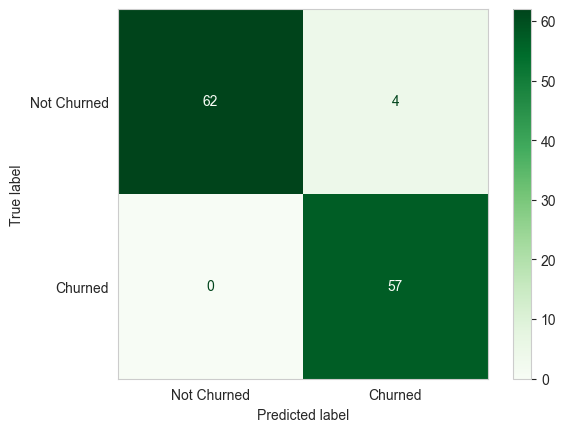

In [174]:
# confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
 display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Greens')
plt.grid(False)
# save confusion matrix
plt.savefig('img/confusion_matrix.png')
plt.show()


In [113]:
# import classification report
from sklearn.metrics import classification_report

# classification report
print(classification_report(predForest.select('label').collect(), predForest.select('prediction').collect()))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97        66
           1       0.93      1.00      0.97        57

    accuracy                           0.97       123
   macro avg       0.97      0.97      0.97       123
weighted avg       0.97      0.97      0.97       123



In [186]:
# make table of classification report
report = classification_report(predForest.select('label').collect(), predForest.select('prediction').collect(), output_dict=True)
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
0,1.000000,0.939394,0.968750,66.00000
1,0.934426,1.000000,0.966102,57.00000
accuracy,0.967480,0.967480,0.967480,0.96748
macro avg,0.967213,0.969697,0.967426,123.00000
weighted avg,0.969612,0.967480,0.967523,123.00000


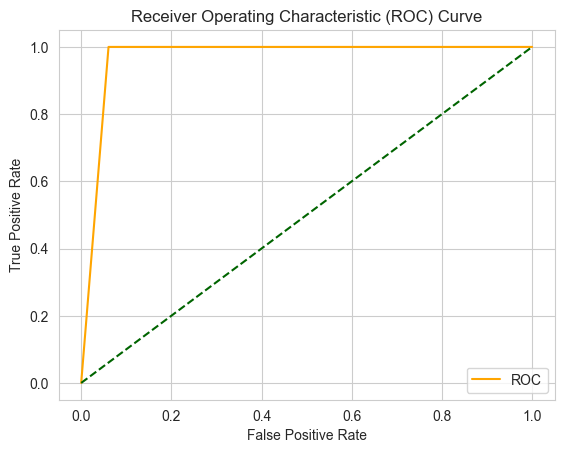

In [179]:
# import roc curve
from sklearn.metrics import roc_curve

# roc curve
fpr, tpr, thresholds = roc_curve(predForest.select('label').collect(), predForest.select('prediction').collect())

# plot roc curve 
plt.plot(fpr, tpr, color='orange', label='ROC')
# greens

plt.plot([0, 1], [0, 1], color='darkgreen', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
# save roc curve
plt.savefig('img/roc_curve.png')
plt.show()


In [169]:
# get feature importance
importances = cvForest.bestModel.featureImportances

# get feature names
feature_names = num_features + cat_features


In [172]:
# convert sparsevector to python dictionary
importance_dict = dict(zip(feature_names, importances))

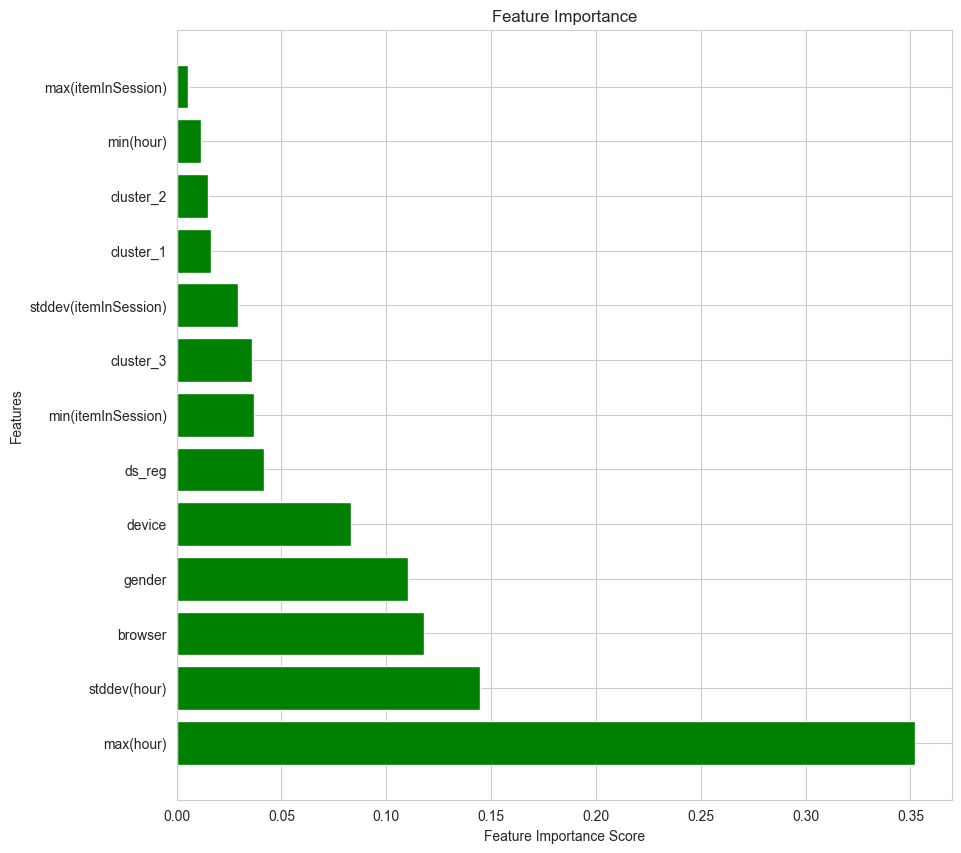

In [180]:
# sort dictionary by values
importance_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}

# plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(list(importance_dict.keys()), list(importance_dict.values()), color='g')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
# save feature importance
plt.savefig('img/feature_importance.png')
plt.show()

In [192]:
# run logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# fit logistic regression
lrModel = lr.fit(train)

# get predictions
predictions = lrModel.transform(validation)

# get metrics
print("The eval. metrics for Logistic Regression:")
print("F-1 Score {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))


The eval. metrics for Logistic Regression:
F-1 Score 0.7560975609756098
Accuracy 0.7502061977141511


In [193]:
# grid search for logistic regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# cross validation
crossval = CrossValidator(estimator=lr,
                            estimatorParamMaps=paramGrid,
                            evaluator=MulticlassClassificationEvaluator(),
                            numFolds=3)

# fit cross validation
cvModel = crossval.fit(train)

# get predictions
predictions = cvModel.transform(validation)

# get metrics
print("The eval. metrics for Logistic Regression:")
print("F-1 Score {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))




23/01/02 01:11:26 WARN CacheManager: Asked to cache already cached data.
23/01/02 01:11:26 WARN CacheManager: Asked to cache already cached data.
The eval. metrics for Logistic Regression:
F-1 Score 0.8861788617886179
Accuracy 0.8862390527659905


In [194]:
# run linear support vector machine
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# fit linear support vector machine
lsvcModel = lsvc.fit(train)

# get predictions
predictions = lsvcModel.transform(validation)

# get metrics
print("The eval. metrics for Linear Support Vector Machine:")
print("F-1 Score {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))



The eval. metrics for Linear Support Vector Machine:
F-1 Score 0.8373983739837398
Accuracy 0.8375493304004658


In [195]:
# grid search for linear support vector machine
paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.1, 0.01]) \
    .build()

# cross validation
crossval = CrossValidator(estimator=lsvc,
                            estimatorParamMaps=paramGrid,
                            evaluator=MulticlassClassificationEvaluator(),
                            numFolds=3)

# fit cross validation
cvSVC = crossval.fit(train)

# get predictions
predictions = cvSVC.transform(validation)

# get metrics
print("The eval. metrics for Linear Support Vector Machine:")
print("F-1 Score {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "accuracy"})))
print("Accuracy {}".format(evaluator.evaluate(predictions, {evaluator.metricName : "f1"})))


The eval. metrics for Linear Support Vector Machine:
F-1 Score 0.8943089430894309
Accuracy 0.8939452869682538
